In [1]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso, HuberRegressor, BayesianRidge, Ridge
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from IPython import display
from glob import glob
from fastprogress import progress_bar
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")


def seed_everything(seed=7777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    # tf.random.set_seed(seed)


SEED = 7777
seed_everything(SEED)

In [2]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger('after_competition')

In [3]:
base_dir  = './input/osic-pulmonary-fibrosis-progression/'

# preprocess

## construct train df

In [4]:
train_df = pd.read_csv(base_dir + 'train.csv')
output = pd.DataFrame()

gb = train_df.groupby('Patient')
tqdm = progress_bar(gb, total=len(gb))

for ID, usr_df in tqdm:
    usr_output = pd.DataFrame()
    for week, tmp_df in usr_df.groupby('Weeks'):

        rename_cols = {
            'Weeks': 'base_Week',
            'FVC': 'base_FVC',
            'Percent': 'base_Percent',
        }
        tmp_df = tmp_df.rename(columns=rename_cols)
        
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent']
        _usr_op = usr_df.drop(columns=drop_cols)
        _usr_op = _usr_op.rename(columns={'Weeks': 'target_week'})
        _usr_op = _usr_op.merge(tmp_df, on='Patient')
        _usr_op['weeks_passed'] = _usr_op['target_week'] - _usr_op['base_Week']
        
        usr_output = pd.concat([usr_output, _usr_op])
    output = pd.concat([output, usr_output])

#train = output[output['Week_passed'] != 0].reset_index(drop=True)
train_df = output.reset_index(drop=True)

train_df['phase'] = 'train'
print(train_df.shape)

#train_df = train_df[train_df.weeks_passed > 0]
train_df

(13707, 11)


,Patient,target_week,FVC,base_Week,base_FVC,base_Percent,Age,Sex,SmokingStatus,weeks_passed,phase
0,ID00007637202177411956430,-4,2315,-4,2315,58.253649,79,Male,Ex-smoker,0,train
1,ID00007637202177411956430,5,2214,-4,2315,58.253649,79,Male,Ex-smoker,9,train
2,ID00007637202177411956430,7,2061,-4,2315,58.253649,79,Male,Ex-smoker,11,train
3,ID00007637202177411956430,9,2144,-4,2315,58.253649,79,Male,Ex-smoker,13,train
4,ID00007637202177411956430,11,2069,-4,2315,58.253649,79,Male,Ex-smoker,15,train
...,...,...,...,...,...,...,...,...,...,...,...
13702,ID00426637202313170790466,13,2712,59,2774,68.117081,73,Male,Never smoked,-46,train
13703,ID00426637202313170790466,19,2978,59,2774,68.117081,73,Male,Never smoked,-40,train
13704,ID00426637202313170790466,31,2908,59,2774,68.117081,73,Male,Never smoked,-28,train
13705,ID00426637202313170790466,43,2975,59,2774,68.117081,73,Male,Never smoked,-16,train


## construct test input df

In [5]:
sub_df = pd.read_csv(base_dir + 'sample_submission.csv')
sub_df['Patient'] = sub_df.Patient_Week.apply(lambda x: x.split('_')[0])
sub_df['target_week'] = sub_df.Patient_Week.apply(lambda x: x.split('_')[1]).astype(int)

test_df = pd.read_csv(base_dir + 'test.csv')
test_df = test_df.rename(columns=rename_cols)
test_df = sub_df.drop(columns=['FVC', 'Confidence']).merge(test_df, on='Patient')
test_df['weeks_passed'] = test_df['target_week'] - test_df['base_Week']

test_df['phase'] = 'test'
print(test_df.shape)
test_df.sample(5)

sub_df = pd.read_csv(base_dir + 'sample_submission.csv')
sub_df.sample(10)

(730, 11)


,Patient_Week,FVC,Confidence
492,ID00422637202311677017371_86,2000,100
699,ID00426637202313170790466_127,2000,100
361,ID00421637202311550012437_60,2000,100
379,ID00426637202313170790466_63,2000,100
675,ID00419637202311204720264_123,2000,100
31,ID00421637202311550012437_-6,2000,100
495,ID00419637202311204720264_87,2000,100
238,ID00423637202312137826377_35,2000,100
263,ID00423637202312137826377_40,2000,100
51,ID00421637202311550012437_-2,2000,100


In [6]:
all_df = pd.concat([train_df, test_df], axis=0)
all_df

,Patient,target_week,FVC,base_Week,base_FVC,base_Percent,Age,Sex,SmokingStatus,weeks_passed,phase,Patient_Week
0,ID00007637202177411956430,-4,2315.0,-4,2315,58.253649,79,Male,Ex-smoker,0,train,NaN
1,ID00007637202177411956430,5,2214.0,-4,2315,58.253649,79,Male,Ex-smoker,9,train,NaN
2,ID00007637202177411956430,7,2061.0,-4,2315,58.253649,79,Male,Ex-smoker,11,train,NaN
3,ID00007637202177411956430,9,2144.0,-4,2315,58.253649,79,Male,Ex-smoker,13,train,NaN
4,ID00007637202177411956430,11,2069.0,-4,2315,58.253649,79,Male,Ex-smoker,15,train,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,NaN,0,2925,71.824968,73,Male,Never smoked,129,test,ID00426637202313170790466_129
726,ID00426637202313170790466,130,NaN,0,2925,71.824968,73,Male,Never smoked,130,test,ID00426637202313170790466_130
727,ID00426637202313170790466,131,NaN,0,2925,71.824968,73,Male,Never smoked,131,test,ID00426637202313170790466_131
728,ID00426637202313170790466,132,NaN,0,2925,71.824968,73,Male,Never smoked,132,test,ID00426637202313170790466_132


## feature

In [7]:
all_df['percent_reciprocal'] = 1 / all_df.base_Percent
all_df['percent_ratio'] = all_df.base_FVC / all_df.base_Percent

def calculate_height(row):
    height = 0
    if row['Sex'] == 'Male' or 'Female':
        height = (((row['base_FVC'] / 933.33) + 0.026 * row['Age'] + 2.89) /
                  0.0443)
        return int(height)


all_df['Height'] = all_df.apply(calculate_height, axis=1)


def FEV1(row):
    FEV = 0
    if row['Sex'] == 'Male':
        FEV = (0.84 * row['base_FVC'] - 0.23)
    else:
        FEV = (0.84 * row['base_FVC'] - 0.36)
    return FEV


all_df['FEV'] = all_df.apply(FEV1, axis=1)
all_df['FEV_ratio'] = all_df.FEV / all_df.base_FVC


# onehot
all_df = pd.concat([
    all_df,
    pd.get_dummies(all_df.Sex),
    pd.get_dummies(all_df.SmokingStatus)
], axis=1)
all_df

,Patient,target_week,FVC,base_Week,base_FVC,base_Percent,Age,Sex,SmokingStatus,weeks_passed,...,percent_reciprocal,percent_ratio,Height,FEV,FEV_ratio,Female,Male,Currently smokes,Ex-smoker,Never smoked
0,ID00007637202177411956430,-4,2315.0,-4,2315,58.253649,79,Male,Ex-smoker,0,...,0.017166,39.740,167,1944.37,0.839901,0,1,0,1,0
1,ID00007637202177411956430,5,2214.0,-4,2315,58.253649,79,Male,Ex-smoker,9,...,0.017166,39.740,167,1944.37,0.839901,0,1,0,1,0
2,ID00007637202177411956430,7,2061.0,-4,2315,58.253649,79,Male,Ex-smoker,11,...,0.017166,39.740,167,1944.37,0.839901,0,1,0,1,0
3,ID00007637202177411956430,9,2144.0,-4,2315,58.253649,79,Male,Ex-smoker,13,...,0.017166,39.740,167,1944.37,0.839901,0,1,0,1,0
4,ID00007637202177411956430,11,2069.0,-4,2315,58.253649,79,Male,Ex-smoker,15,...,0.017166,39.740,167,1944.37,0.839901,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,NaN,0,2925,71.824968,73,Male,Never smoked,129,...,0.013923,40.724,178,2456.77,0.839921,0,1,0,0,1
726,ID00426637202313170790466,130,NaN,0,2925,71.824968,73,Male,Never smoked,130,...,0.013923,40.724,178,2456.77,0.839921,0,1,0,0,1
727,ID00426637202313170790466,131,NaN,0,2925,71.824968,73,Male,Never smoked,131,...,0.013923,40.724,178,2456.77,0.839921,0,1,0,0,1
728,ID00426637202313170790466,132,NaN,0,2925,71.824968,73,Male,Never smoked,132,...,0.013923,40.724,178,2456.77,0.839921,0,1,0,0,1


## numerical

In [8]:
from sklearn.preprocessing import RobustScaler, StandardScaler


numerical_col = [
    'target_week', 
    'base_Week', 
    'base_FVC', 
    'base_Percent', 
    'Age',
    'weeks_passed', 
    'Height', 
    'FEV',
    'percent_reciprocal',
    'FEV_ratio',
    'percent_ratio',
]


t = RobustScaler().fit(all_df[all_df.phase == 'train'][numerical_col])
#t = StandardScaler().fit(all_df[all_df.phase == 'train'][numerical_col])

all_df[numerical_col] = t.transform(all_df[numerical_col])
all_df

,Patient,target_week,FVC,base_Week,base_FVC,base_Percent,Age,Sex,SmokingStatus,weeks_passed,...,percent_reciprocal,percent_ratio,Height,FEV,FEV_ratio,Female,Male,Currently smokes,Ex-smoker,Never smoked
0,ID00007637202177411956430,-0.888889,2315.0,-0.888889,-0.336134,-0.693260,1.222222,Male,Ex-smoker,0.000000,...,0.875877,0.355056,-0.08,-0.336086,-0.244548,0,1,0,1,0
1,ID00007637202177411956430,-0.638889,2214.0,-0.888889,-0.336134,-0.693260,1.222222,Male,Ex-smoker,0.375000,...,0.875877,0.355056,-0.08,-0.336086,-0.244548,0,1,0,1,0
2,ID00007637202177411956430,-0.583333,2061.0,-0.888889,-0.336134,-0.693260,1.222222,Male,Ex-smoker,0.458333,...,0.875877,0.355056,-0.08,-0.336086,-0.244548,0,1,0,1,0
3,ID00007637202177411956430,-0.527778,2144.0,-0.888889,-0.336134,-0.693260,1.222222,Male,Ex-smoker,0.541667,...,0.875877,0.355056,-0.08,-0.336086,-0.244548,0,1,0,1,0
4,ID00007637202177411956430,-0.472222,2069.0,-0.888889,-0.336134,-0.693260,1.222222,Male,Ex-smoker,0.625000,...,0.875877,0.355056,-0.08,-0.336086,-0.244548,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,2.805556,NaN,-0.777778,0.233427,-0.163583,0.555556,Male,Never smoked,5.375000,...,0.167622,0.465618,0.36,0.233393,0.243727,0,1,0,0,1
726,ID00426637202313170790466,2.833333,NaN,-0.777778,0.233427,-0.163583,0.555556,Male,Never smoked,5.416667,...,0.167622,0.465618,0.36,0.233393,0.243727,0,1,0,0,1
727,ID00426637202313170790466,2.861111,NaN,-0.777778,0.233427,-0.163583,0.555556,Male,Never smoked,5.458333,...,0.167622,0.465618,0.36,0.233393,0.243727,0,1,0,0,1
728,ID00426637202313170790466,2.888889,NaN,-0.777778,0.233427,-0.163583,0.555556,Male,Never smoked,5.500000,...,0.167622,0.465618,0.36,0.233393,0.243727,0,1,0,0,1


In [9]:
feature_columns = [
    'target_week',
    'base_Week',
    'base_FVC',
    'base_Percent',
    'Age',
    'weeks_passed',
    'Height',
    'FEV', 
    'percent_reciprocal',
    'Female',
    'Male', 
    'Currently smokes',
    'Ex-smoker',
    'Never smoked',
    #'Sex',
    #'SmokingStatus',
    'FEV_ratio',
    'percent_ratio',
]

train_df = all_df.loc[all_df.phase == 'train'].reset_index(drop=True)
test_df = all_df.loc[all_df.phase == 'test']


train_df.reset_index(inplace=True)
train_df[feature_columns]

,target_week,base_Week,base_FVC,base_Percent,Age,weeks_passed,Height,FEV,percent_reciprocal,Female,Male,Currently smokes,Ex-smoker,Never smoked,FEV_ratio,percent_ratio
0,-0.888889,-0.888889,-0.336134,-0.693260,1.222222,0.000000,-0.08,-0.336086,0.875877,0,1,0,1,0,-0.244548,0.355056
1,-0.638889,-0.888889,-0.336134,-0.693260,1.222222,0.375000,-0.08,-0.336086,0.875877,0,1,0,1,0,-0.244548,0.355056
2,-0.583333,-0.888889,-0.336134,-0.693260,1.222222,0.458333,-0.08,-0.336086,0.875877,0,1,0,1,0,-0.244548,0.355056
3,-0.527778,-0.888889,-0.336134,-0.693260,1.222222,0.541667,-0.08,-0.336086,0.875877,0,1,0,1,0,-0.244548,0.355056
4,-0.472222,-0.888889,-0.336134,-0.693260,1.222222,0.625000,-0.08,-0.336086,0.875877,0,1,0,1,0,-0.244548,0.355056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13702,-0.416667,0.861111,0.092437,-0.308298,0.555556,-1.916667,0.24,0.092424,0.333108,0,1,0,0,1,0.142859,0.465618
13703,-0.250000,0.861111,0.092437,-0.308298,0.555556,-1.666667,0.24,0.092424,0.333108,0,1,0,0,1,0.142859,0.465618
13704,0.083333,0.861111,0.092437,-0.308298,0.555556,-1.166667,0.24,0.092424,0.333108,0,1,0,0,1,0.142859,0.465618
13705,0.416667,0.861111,0.092437,-0.308298,0.555556,-0.666667,0.24,0.092424,0.333108,0,1,0,0,1,0.142859,0.465618


# LGB

In [10]:
def get_scored_index(df):
    scored_index = []
    gb = df.groupby(['Patient', 'base_Week'])
    for g in gb:
        scored_index.append(g[1].target_week.index.values[-3:])
    return np.array(scored_index).flatten()


def laplace_log_likelihood(preds, ys, confidence, mean=True, index=None):
    std_clip = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(preds - ys), 1000)
    metric = -2**0.5 * delta / std_clip - np.log(2 ** 0.5 * std_clip)
    
    if np.any(index): metric = metric[index]
    if mean: return metric.mean()
    return metric

In [11]:
scored_index = get_scored_index(train_df)


def run_single(models,
               train_df,
               test_df,
               fold_idx,
               feature_columns,
               target='FVC',
               fold_num=0,
               submit=False):

    # index
    trn_idx = fold_idx[0]
    val_idx = fold_idx[1]

    # shuffle
    #trn_idx = np.random.permutation(trn_idx)

    # data
    x_trn = train_df[feature_columns].iloc[trn_idx].values
    y_trn = train_df['FVC'].iloc[trn_idx].values
    x_val = train_df[feature_columns].iloc[val_idx].values
    y_val = train_df['FVC'].iloc[val_idx].values

    # fit
    for m in models:
        m.fit(x_trn, y_trn)

    # test
    test_preds = [m.predict(test_df[feature_columns]) for m in models]
    predict = test_preds[0]
    confidence = test_preds[1] - test_preds[2]

    #submit
    if submit: return predict, confidence

    # predict
    trn_preds = [m.predict(x_trn) for m in models]
    trn_conf = trn_preds[1] - trn_preds[2]
    score = laplace_log_likelihood(trn_preds[0],
                                   y_trn,
                                   trn_conf,
                                   index=np.where(
                                       np.isin(trn_idx, scored_index))[0])

    val_preds = [m.predict(x_val) for m in models]
    val_conf = val_preds[1] - val_preds[2]
    val_score = laplace_log_likelihood(val_preds[0],
                                       y_val,
                                       val_conf,
                                       index=np.where(
                                           np.isin(val_idx, scored_index))[0])

    # oof
    oof = np.zeros(len(train_df))
    oof_conf = np.zeros(len(train_df))
    oof[val_idx] = val_preds[0]
    oof_conf[val_idx] = val_conf

    # feature importance
    try:
        feature_importance = models[0].feature_importances_
    except AttributeError:
        try:
            feature_importance = models[0].coef_
        except AttributeError:
            feature_importance = 0
    #show_feature_importance(feature_importance, feature_columns)

    return oof, oof_conf, predict, confidence, feature_importance, val_score


def show_feature_importance(feature_importance,
                            feature_columns,
                            name=None,
                            save=True):
    plt.figure(figsize=(6, 4))
    sns.barplot(x=feature_importance, y=feature_columns)
    plt.suptitle(f'{name}')
    if save:
        name = time.ctime().replace(' ', '_').replace(':', '-')
        plt.savefig(f'feature_importance_{name}.png')
    plt.show()


def run_kfolds(models,
               train_df,
               test_df,
               feature_columns,
               target='FVC',
               folds=5,
               submit=False):

    oof = np.zeros(len(train_df))
    oof_conf = np.zeros(len(train_df))
    preds = np.zeros(len(test_df))
    preds_conf = np.zeros(len(test_df))

    feature_importance = 0
    cv_scores = []

    gkf = GroupKFold(folds)
    for n, fold_idx in enumerate(gkf.split(train_df, groups=train_df.Patient)):

        oof_, oof_conf_, pred_, conf_, feat_import_, score = run_single(
            models,
            train_df,
            test_df,
            fold_idx,
            feature_columns,
            target=target,
            fold_num=n,
            submit=submit)

        oof += oof_
        oof_conf += oof_conf_
        preds += pred_ / folds
        preds_conf += conf_ / folds
        feature_importance += feat_import_ / folds
        cv_scores.append(score)

    feature_importance = np.array(feature_importance) / folds
    show_feature_importance(feature_importance, feature_columns,
                            models[0].__class__)

    # log
    logger.info(
        f'==================={models[0].__class__} fold========================'
    )
    logger.info(f'CV mae: {mean_absolute_error(train_df[target], oof): .6f}')
    cv_score = laplace_log_likelihood(oof,
                                      train_df[target],
                                      oof_conf,
                                      index=scored_index)
    logger.info(
        f'CV score: {np.mean(cv_score): .6f} ± {np.std(cv_scores): .6f}')
    logger.info(f"\n")

    return oof, oof_conf, preds, preds_conf

## state 1

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

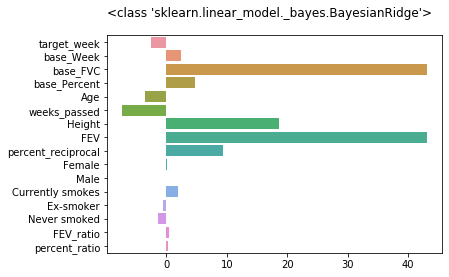

===================<class 'sklearn.linear_model._bayes.BayesianRidge'> fold========================
CV mae:  141.097861
CV score: -6.709152 ±  0.166957




[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

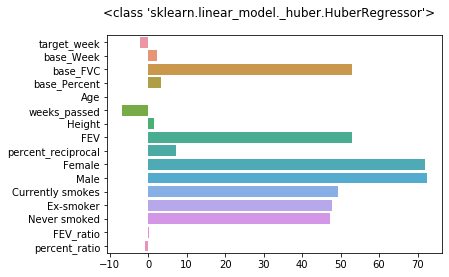

===================<class 'sklearn.linear_model._huber.HuberRegressor'> fold========================
CV mae:  139.131955
CV score: -6.684595 ±  0.169663




[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

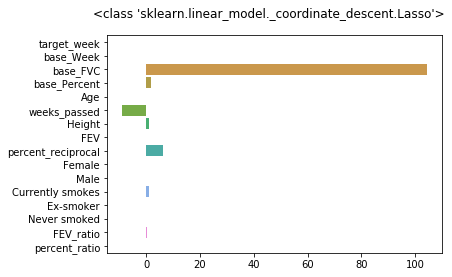

===================<class 'sklearn.linear_model._coordinate_descent.Lasso'> fold========================
CV mae:  140.803059
CV score: -6.707719 ±  0.162642




[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

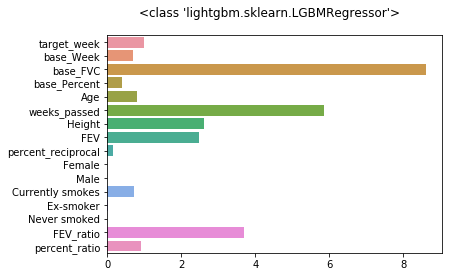

===================<class 'lightgbm.sklearn.LGBMRegressor'> fold========================
CV mae:  153.989405
CV score: -6.762458 ±  0.197628




[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

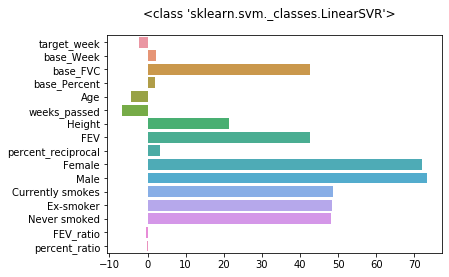

===================<class 'sklearn.svm._classes.LinearSVR'> fold========================
CV mae:  138.421494
CV score: -6.665948 ±  0.169715




[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

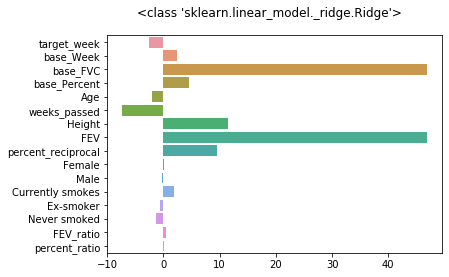

===================<class 'sklearn.linear_model._ridge.Ridge'> fold========================
CV mae:  141.087045
CV score: -6.709253 ±  0.166990




In [12]:
# state 1 
param = {
    'num_leaves': 5,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'feature_fraction': 0.8,
    'max_depth': 4,
    'metric': 'rmse',
    'min_child_samples': 31,
    'min_child_weight': 0.001,
    'n_estimators': 70,
    'reg_alpha': 2.1,
    'reg_lambda': 1.4,
    'force_col_wise':True
}
alpha = 0.75


model_list = [
    BayesianRidge(),                              # -6.707331
    HuberRegressor(max_iter=200),                 # -6.696623
    Lasso(),                                      # -6.693470
    lgb.LGBMRegressor(objective='regression_l1',  # -6.737370
                      alpha=0.5, 
                      **param),   
    LinearSVR(C=50),                              # -6.697384
    Ridge(alpha=0.5),                             # -6.707246
]


oof_df = pd.DataFrame()
pred_df = pd.DataFrame()

for idx, m in enumerate(model_list):
    models = [
        m,
        lgb.LGBMRegressor(objective='quantile', alpha=alpha, **param),
        lgb.LGBMRegressor(objective='quantile', alpha=1 - alpha, **param)
    ]

    oof, oof_conf, predict, confidence = run_kfolds(
        models,
        train_df,
        test_df,
        feature_columns,
        target='FVC',
        folds=10,
        submit=False,
    )
    oof_df[idx] = oof
    pred_df[idx] = predict

In [13]:
score = laplace_log_likelihood(oof_df.mean(axis=1),
                               train_df.FVC,
                               oof_conf,
                               index=scored_index)
mae = mean_absolute_error(oof_df[-3:].mean(axis=1), train_df.FVC[-3:])
logger.info(f'state 1: cv score: {score: .6f}, cv mae: {mae:.6f}\n')

state 1: cv score: -6.689995, cv mae: 60.178434



## stack 2

In [14]:
# state 2 feature

# normalize
oof_df['mean'] = oof_df.mean(axis=1)
pred_df['mean'] = pred_df.mean(axis=1)
t2 = RobustScaler().fit(oof_df)
oof_df = pd.DataFrame(t2.transform(oof_df))
pred_df = pd.DataFrame(t2.transform(pred_df))

# create state dataframe
train_df2 = train_df.copy()
test_df2 = test_df.copy()

model_name = [f'model{i}' for i in range(len(model_list))]
model_name.append('mean')
train_df2[model_name] = oof_df
test_df2[model_name] = pred_df

feature_columns2 = feature_columns.copy()
for i in range(len(model_list)):
    feature_columns2.append(f'model{i}')
feature_columns2.append('mean')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

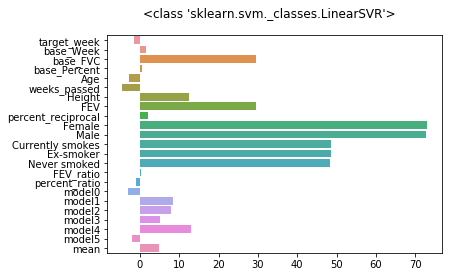

===================<class 'sklearn.svm._classes.LinearSVR'> fold========================
CV mae:  138.493902
CV score: -6.657397 ±  0.170727




In [15]:
# state 2
param = {
    'num_leaves': 5,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'feature_fraction': 0.8,
    'max_depth': 4,
    'metric': 'rmse',
    'min_child_samples': 31,
    'min_child_weight': 0.001,
    'n_estimators': 70,
    'reg_alpha': 2.1,
    'reg_lambda': 1.4,
}
alpha = 0.75


model_list = [
    #HuberRegressor(max_iter=200),                 # -6.684595
    #Lasso(),                                      # -6.707719
    LinearSVR(C=50),                              # -6.665948
    #Ridge(alpha=0.5),                             # -6.709253
]


oof_df = pd.DataFrame()
pred_df = pd.DataFrame()

for idx, m in enumerate(model_list):
    models = [
        m,
        lgb.LGBMRegressor(objective='quantile', alpha=alpha, **param),
        lgb.LGBMRegressor(objective='quantile', alpha=1 - alpha, **param)
    ]

    oof, oof_conf, predict, confidence = run_kfolds(
        models,
        train_df2,
        test_df2,
        #model_name,
        feature_columns2,
        target='FVC',
        folds=10,
        submit=False,
    )
    oof_df[idx] = oof
    pred_df[idx] = predict

In [16]:
score = laplace_log_likelihood(oof_df.mean(axis=1),
                               train_df.FVC,
                               oof_conf,
                               index=scored_index)
mae = mean_absolute_error(oof_df[-3:].mean(axis=1), train_df.FVC[-3:])
logger.info(f'state 2: cv score: {score: .6f}, cv mae: {mae:.6f}')

state 2: cv score: -6.657397, cv mae: 62.032934


# result

In [17]:
oof_preds = oof_df.mean(axis=1)
pred_df = pred_df.mean(axis=1)

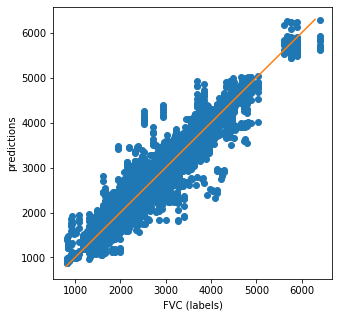

In [18]:
plt.figure(figsize=(5, 5))
plt.scatter(train_df['FVC'], oof_preds)
plt.plot(range(800, 6300), range(800, 6300), color='C1')

plt.ylabel('predictions')
plt.xlabel('FVC (labels)')
plt.show()

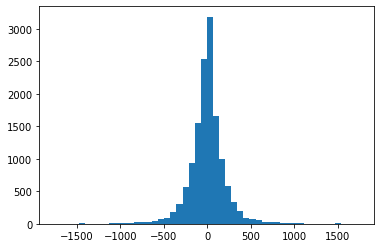

In [19]:
delta = oof_preds - train_df['FVC']
plt.hist(delta, bins=50)
plt.show()

In [20]:
score = laplace_log_likelihood(oof_df.mean(axis=1), train_df.FVC, oof_conf, mean=False)
train_df['score'] = score
train_df['predict'] = oof_df.mean(axis=1)
train_df['confidence'] = oof_conf
bad_df = train_df.iloc[scored_index][score < -6.9].copy()
bad_df

,index,Patient,target_week,FVC,base_Week,base_FVC,base_Percent,Age,Sex,SmokingStatus,...,FEV,FEV_ratio,Female,Male,Currently smokes,Ex-smoker,Never smoked,score,predict,confidence
6,6,ID00007637202177411956430,0.027778,2000.0,-0.888889,-0.336134,-0.693260,1.222222,Male,Ex-smoker,...,-0.336086,-0.244548,0,1,0,1,0,-7.094191,2210.948542,221.277539
89,89,ID00009637202177434476278,0.888889,3214.0,-0.555556,0.919701,0.361668,0.111111,Male,Ex-smoker,...,0.919568,0.615855,0,1,0,1,0,-7.360234,3483.846384,268.816529
98,98,ID00009637202177434476278,0.888889,3214.0,-0.527778,0.873016,0.316197,0.111111,Male,Ex-smoker,...,0.872890,0.595343,0,1,0,1,0,-7.121149,3437.501226,262.223773
105,105,ID00009637202177434476278,0.138889,3625.0,-0.472222,1.139122,0.575385,0.111111,Male,Ex-smoker,...,1.138958,0.705204,0,1,0,1,0,-6.967292,3819.768249,295.154006
106,106,ID00009637202177434476278,0.472222,3390.0,-0.472222,1.139122,0.575385,0.111111,Male,Ex-smoker,...,1.138958,0.705204,0,1,0,1,0,-7.958064,3779.518511,277.336724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13642,13642,ID00426637202313170790466,0.416667,2975.0,-0.583333,0.212885,-0.184667,0.555556,Male,Never smoked,...,0.212854,0.229684,0,1,0,0,1,-7.037322,2767.646509,255.835675
13651,13651,ID00426637202313170790466,0.416667,2975.0,-0.527778,0.225023,-0.172208,0.555556,Male,Never smoked,...,0.224991,0.238008,0,1,0,0,1,-6.943487,2784.621509,255.835675
13668,13668,ID00426637202313170790466,0.083333,2908.0,-0.416667,0.034547,-0.367718,0.555556,Male,Never smoked,...,0.034542,0.098189,0,1,0,0,1,-7.341674,2647.249026,250.736159
13669,13669,ID00426637202313170790466,0.416667,2975.0,-0.416667,0.034547,-0.367718,0.555556,Male,Never smoked,...,0.034542,0.098189,0,1,0,0,1,-7.790615,2604.369132,302.818908


In [21]:
bad_df[numerical_col] = t.inverse_transform(bad_df[numerical_col])
bad_df['preds_diff'] = bad_df['predict'] - bad_df['FVC']

bad_df[[
    'Patient', 'base_Week', 'weeks_passed', 'base_FVC', 'FVC', 'predict',
    'preds_diff', 'confidence', 'score', 'Age', 'Sex', 'SmokingStatus'
]].sort_values('score', ascending=True).head(50)

,Patient,base_Week,weeks_passed,base_FVC,FVC,predict,preds_diff,confidence,score,Age,Sex,SmokingStatus
10185,ID00319637202283897208687,16.0,36.0,2951.0,4247.0,2812.395109,-1434.604891,159.457747,-14.287245,72.0,Male,Ex-smoker
6652,ID00197637202246865691526,57.0,-16.0,3283.0,2312.0,3333.556865,1021.556865,171.193375,-13.750280,65.0,Male,Currently smokes
10184,ID00319637202283897208687,16.0,24.0,2951.0,4238.0,2854.246261,-1383.753739,174.742636,-13.603010,72.0,Male,Ex-smoker
2310,ID00076637202199015035026,5.0,35.0,2182.0,2914.0,2081.193208,-832.806792,148.252543,-13.289818,51.0,Male,Never smoked
10186,ID00319637202283897208687,16.0,53.0,2951.0,4218.0,2756.853222,-1461.146778,185.002927,-13.211222,72.0,Male,Ex-smoker
13173,ID00414637202310318891556,16.0,47.0,2863.0,1612.0,2694.129353,1082.129353,185.913525,-13.178691,65.0,Male,Never smoked
6634,ID00197637202246865691526,30.0,11.0,3399.0,2312.0,3364.171336,1052.171336,188.353676,-13.093183,65.0,Male,Currently smokes
6644,ID00197637202246865691526,41.0,16.0,2312.0,3283.0,2271.948918,-1011.051082,199.625114,-12.727362,65.0,Male,Currently smokes
13155,ID00414637202310318891556,12.0,51.0,3006.0,1612.0,2820.615772,1208.615772,200.201075,-12.709862,65.0,Male,Never smoked
6615,ID00197637202246865691526,11.0,19.0,2360.0,3399.0,2307.881846,-1091.118154,221.851690,-12.123173,65.0,Male,Currently smokes


In [22]:
submission = pd.DataFrame()

submission['Patient_Week'] = test_df.Patient_Week
submission['FVC'] = pred_df
submission['Confidence'] = confidence
submission

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3078.393657,290.274540
1,ID00419637202311204720264_-11,3074.879558,304.372228
2,ID00419637202311204720264_-10,3071.647826,303.018048
3,ID00419637202311204720264_-9,3068.416094,302.810788
4,ID00419637202311204720264_-8,3065.184361,300.545699
...,...,...,...
725,ID00426637202313170790466_129,2490.965155,393.936966
726,ID00426637202313170790466_130,2487.733422,393.936966
727,ID00426637202313170790466_131,2484.501690,393.936966
728,ID00426637202313170790466_132,2481.269957,393.936966


In [23]:
submission.to_csv('submission.csv', index=False)